## Import libraries

In [ ]:
!pip install torchtext==0.9.1
!pip install natasha
!pip install swifter
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

  Using cached torchtext-0.9.1-cp37-cp37m-manylinux1_x86_64.whl (7.1 MB)
     |████████████████████████████████| 804.1 MB 3.2 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.
     |████████████████████████████████| 34.4 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 4.5 MB/s 
     |████████████████████████████████| 41 kB 97 k

--2021-11-25 13:52:02--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  41.6MB/s    in 1.2s    

2021-11-25 13:52:04 (41.6 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from string import punctuation

import os
import random

import torch

import torch.nn as nn
import torch.optim

from tqdm.notebook import tqdm_notebook as tqdm
from tqdm.notebook import trange
from torch.utils.data import DataLoader
import torch.nn.functional as F
from navec import Navec
import razdel
import copy
import pymorphy2

import swifter

In [ ]:
SEED = 1234


def enable_reproducibility(
        seed=SEED, raise_if_no_deterministic=True,
        cudnn_deterministic=True, disable_cudnn_benchmarking=True):
    # https://pytorch.org/docs/stable/notes/randomness.html#avoiding-nondeterministic-algorithms
    torch.use_deterministic_algorithms(raise_if_no_deterministic)

    # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
    
    torch.backends.cudnn.benchmark = not disable_cudnn_benchmarking
    torch.backends.cudnn.deterministic = cudnn_deterministic

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
enable_reproducibility()

## Upload Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_json(r'/content/drive/MyDrive/ColabNotebooks/FarPost/dataset-hackaton.json', lines=True)
train = train.sample(frac=1).reset_index(drop=True)

test = pd.read_json(r'/content/drive/MyDrive/ColabNotebooks/FarPost/hideout-public.json', lines=True)

In [ ]:
print(train.shape)
train.head()

In [ ]:
print(test.shape)
test.head()

(42255, 1)


,title
0,"Шланг GRINDA ""CLASSIC"" 1/2"" х 50 м 8-429001-1/..."
1,Триммер электрический DDE ET1600RV
2,Лестница 3-секционная алюминиевая TOR VL3-17
3,Полотенцесушитель Лесенка (полка) 40*80 электр...
4,Газонокосилка аккумуляторная HONDA HRG416XBPEE...


Class Distribution. They are not balanced, gonna use weights

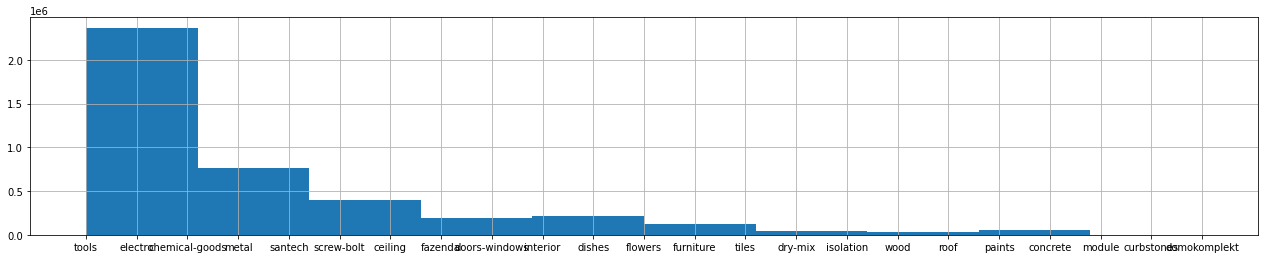

In [ ]:
plt.figure(figsize=(22, 4))
train.dir.hist()

## Preprocessing data

In [ ]:
nltk.download('stopwords')
ru_stopwords = nltk.corpus.stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preproc(sentence):
  tokens = [_.text.lower() for _ in list(razdel.tokenize(str(sentence)))]

  final_sentence = []
  drop_tokens = ['a', 'd', 'e', 'l', 'н', 'p', 'п', 'w', 'g', 'r', 'b', 'ip', '«', '»', 'ф', 'ду', 'б']

  for token  in tokens:
    if (token not in ru_stopwords and token not in punctuation and token not in drop_tokens):
      if token == 'х':
          token = 'x'
      parsed_token = morph.parse(token)[0]
      if 'NUMB' not in parsed_token.tag:
        final_sentence.append(str(parsed_token.normal_form))

  return final_sentence

In [ ]:
%time train['title'] = train['title'].swifter.allow_dask_on_strings(True).apply(preproc)
%time test['title'] = test['title'].swifter.allow_dask_on_strings(True).apply(preproc)

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 29.7 s, sys: 4.85 s, total: 34.5 s
Wall time: 30min 38s


Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 9.79 s, sys: 665 ms, total: 10.5 s
Wall time: 1min 57s


Text augmentation

In [ ]:
augment_data = pd.DataFrame(columns=['title', 'dir'])

for column in ['domokomplekt', 'module', 'curbstones', 'concrete', 'tiles', 'wood', 'isolation', 'flowers', 'dry-mix']:
    augment_data = pd.concat([augment_data, train[train['dir'] == column].apply(lambda x: x.reverse() if type(x) == list else x)], axis=0)
    
train = pd.concat([train, augment_data.reset_index(drop=True)], axis=0).reset_index(drop=True)

## Формирование словаря

In [ ]:
n_classes = len(train['dir'].unique())
print(n_classes)

23


In [ ]:
from collections import Counter
from itertools import chain

from torchtext.vocab import Vocab

PAD_TOKEN = '<pad>'  # default special padding token in Vocab
UNK_TOKEN = '<unk>'  # default special token for unknown tokens in Vocab

words_counter = Counter(chain.from_iterable(map(lambda w: w.lower(), words) for words in 
                                            pd.concat([train['title']], axis=0)))
words_vocab = Vocab(words_counter, min_freq=10,  specials=(PAD_TOKEN, UNK_TOKEN))

PAD_IDX = words_vocab.stoi[PAD_TOKEN]

print(f"Unique tokens in words vocabulary: {len(words_vocab)}")
print(words_vocab.itos[:200])

Unique tokens in words vocabulary: 5637
['<pad>', '<unk>', 'numb', 'мм', 'х', 'x', 'м', 'шт', 'кабель', 'гост', 'a', 'смотреть', 'сверло', 'труба', 'electric', 'schneider', 'светодиодный', 'd', 'e', 'светильник', 'зубр', 'лампа', 'белый', 'л', 'так', 'l', 'н', 'p', 'г', 'кг', 's', 'вт', 'c', 'm', 'нержавеющий', 'f', 'выключатель', 'набор', 'п', 'круг', 'артикул', 'w', 'g', 'розетка', 'ст', 'мл', 'самореза', 'v', 'р', 'стальной', 'чёрный', 'r', 'b', 'ip', 'abb', 'n', 'сталь', 'ключ', 'quot', 'лист', 't', 'металл', '«', '»', 'цвет', 'далее', 'насос', 'комплект', 'din', 'лента', '1/2', 'универсальный', 'подвесной', 'диск', 'phoenix', 'contact', 'ручка', 'stayer', 'h', 'смеситель', 'люстра', 'алюминиевый', 'дерево', 'головка', 'k', 'автоматический', 'рамка', 'сибртех', 'россия', 'matrix', 'полоса', 'legrand', 'болт', 'bosch', 'led', 'шкаф', 'тройник', 'ф', 'aisi', 'ду', 'стать', 'угол', 'уп', 'мастер', 'горячекатаный', 'camozzi', 'обои', 'пильный', 'серый', '№', 'mm', 'хром', 'б', 'тип', '

## Инициализация эмбеддингов

In [ ]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
embed_weights = [[]] * len(words_vocab)
navec_indices = []

for i in range(len(words_vocab)):
  token = words_vocab.itos[i]
  try:
    embed_weights[i] = navec[token]
    navec_indices.append(i)
  except:
    embed_weights[i] = np.random.uniform(-1,1,300)

navec_indices = torch.LongTensor(navec_indices)
embed_weights = torch.tensor(embed_weights, requires_grad=True, dtype=torch.float32)

In [ ]:
print(embed_weights.shape)
print(navec_indices.shape)

torch.Size([5637, 300])
torch.Size([3423])


Посмотрим с насколько большими предложениями мы имеем дело

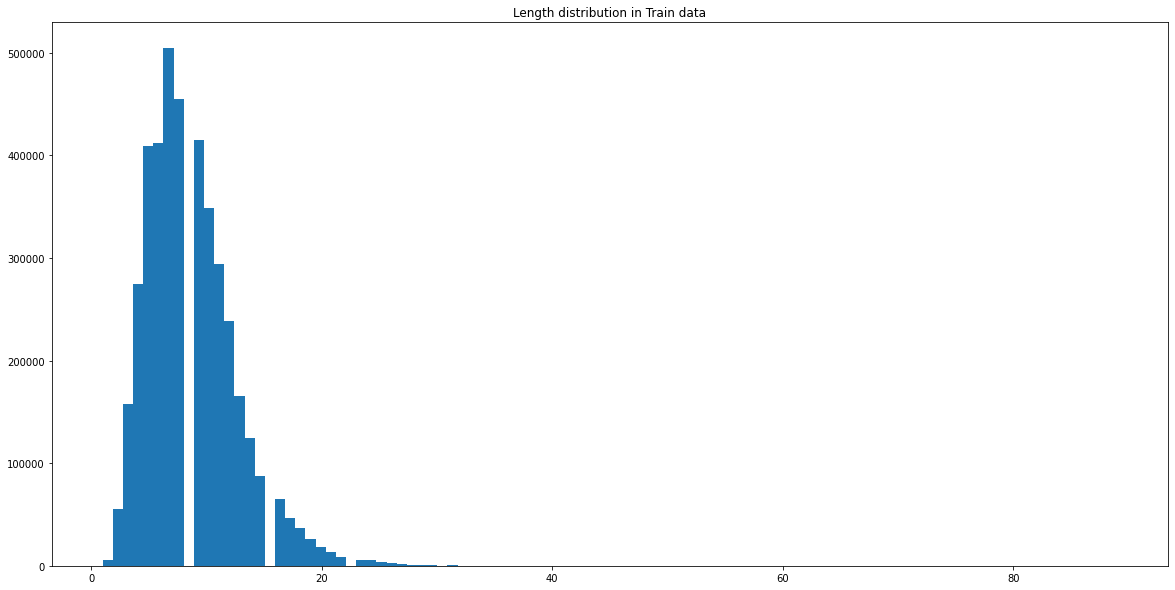

In [ ]:
lengths = map(lambda words_tags: len(words_tags), train['title'])

plt.figure(figsize=[20, 10])
plt.title("Length distribution in Train data")
plt.hist(list(lengths), bins=100);

Label encoding

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['dir'])

LabelEncoder()

In [ ]:
train['dir'] = le.transform(train['dir'])

## Функции, необходимые для составления DataLoader'ов, обучения и валидации нейросети

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def tokens_transform(tokens):
    return [words_vocab.stoi[token] for token in tokens]

def tokens_inverse_transform(indexes):
    return [words_vocab.itos[idx] for idx in indexes]

def collate_batch(batch):
    labels_list, title_t_list = [], []
    for title, label in batch:
        labels_list.append(torch.tensor(label))
        title_t_indices = tokens_transform(title)

        title_t_list.append(torch.tensor(title_t_indices))
    return {
        "title": pad_sequence(title_t_list, batch_first=True, padding_value=PAD_IDX).int(),
        "dir": torch.tensor(labels_list)
    }

def test_collate_batch(batch):
    title_t_list = []
    for title in batch:
        title_t_indices = tokens_transform(title[0])
        title_t_list.append(torch.tensor(title_t_indices))

    return {
        "title": pad_sequence(title_t_list, batch_first=True, padding_value=PAD_IDX).int()
    }

In [ ]:
BATCH_SIZE = 160

train_loader = DataLoader(train.values, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, drop_last=True)
test_loader = DataLoader(test.values, batch_size=BATCH_SIZE, collate_fn=test_collate_batch, shuffle=False)

In [ ]:
def training(model, criterion, optimizer, num_epochs, train_loader, valid_loader=None, sheduler=None, max_grad_norm=2, freezing_epochs=0):
    for e in trange(num_epochs, leave=False):

        model.train()
        
        clf_report = None
        target_names = [str(label) for label in le.inverse_transform(train['dir'].unique())]
        
        valid_acc = 0
        num_iter = 0
        train_loss = 0
        correct = 0
        num_objs = 0

        pbar = tqdm(train_loader, leave=False)
        for batch in pbar:
            optimizer.zero_grad()
            labels = batch["dir"].to(device)
            prediction = model(batch["title"].to(device))
            loss = criterion(prediction, labels)
            loss.backward()
            if e < freezing_epochs:
                model.embedding.weight.grad[navec_indices] = 0

            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            train_loss += loss
            correct += (labels == prediction.argmax(-1)).float().sum()
            num_objs += len(labels)
            num_iter += 1

        if sheduler is not None:
            sheduler.step()
        
        train_acc = correct/num_objs
        print(f"Epoch: {e}")
        print(f"Train Loss: {train_loss / num_iter}, accuracy: {train_acc}")

        if valid_loader:
          valid_loss = 0
          num_iter = 0
          model.eval()
          with torch.no_grad():
              correct = 0
              num_objs = 0

              y_true = torch.tensor([])
              y_pred = torch.tensor([])
              for batch in valid_loader:
                  labels = batch["dir"].to(device)
                  prediction = model(batch["title"].to(device))
                  valid_loss += criterion(prediction, labels)
                  correct += (labels == prediction.argmax(-1)).float().sum()
                  num_objs += len(labels)
                  num_iter += 1

                  y_true = torch.cat((y_true, labels.cpu()), dim=0)
                  y_pred = torch.cat((y_pred, prediction.argmax(-1).cpu()), dim=0)
          
          clf_report = sm.classification_report(y_true, y_pred, target_names=target_names, zero_division=0)
          valid_acc = correct/num_objs
          print(f"Valid Loss: {valid_loss / num_iter}, accuracy: {valid_acc}")

    return train_acc, valid_acc, clf_report

In [ ]:
class Subset():
    """
    Subset of a dataset at specified indices.
    Arguments:
        dataset: The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        if self.indices.shape == ():
            print('this happens: Subset')
            return 1
        else:
            return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]


def KFold_validation(model, criterion, num_epochs, dataset, freezing_epochs=0, k=5):

  num_val_samples = len(dataset) // k
  train_acc = np.array([])
  val_acc = np.array([])

  initial_state = copy.deepcopy(model.state_dict())

  for i in range(k):
      print('Processing fold: ', i + 1)

      """%%%% Initiate new model %%%%""" #in every fold
      model.load_state_dict(initial_state)
      optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
      sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

      if i < k - 1:
        valid_idx = np.arange(len(dataset))[i * num_val_samples:(i + 1) * num_val_samples]
        train_idx = np.concatenate([np.arange(len(dataset))[:i * num_val_samples], np.arange(len(dataset))[(i + 1) * num_val_samples:]], axis=0)
      else:
        valid_idx = np.arange(len(dataset))[i * num_val_samples:]
        train_idx = np.arange(len(dataset))[:i * num_val_samples]

      train_dataset = Subset(dataset, train_idx)
      valid_dataset = Subset(dataset, valid_idx)
      train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, drop_last=True)
      valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=False)

      t_acc, v_acc, clf_report = training(model, criterion, optimizer, num_epochs, train_loader, valid_loader, sheduler=sheduler, freezing_epochs=2)
      train_acc = np.append(train_acc, t_acc.cpu())
      val_acc = np.append(val_acc, v_acc.cpu())

      print(clf_report)

  model.load_state_dict(initial_state)

  return train_acc, val_acc, clf_report

## CNN5

In [ ]:
class CNN_5(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        out_channels,
        kernel_sizes,
        n_classes = 2,
        dropout=0.2,
        embed_weight=None
    ):
        super().__init__()
        if embed_weight == None:
          self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = PAD_IDX)
        else:
          self.embedding = nn.Embedding.from_pretrained(embed_weight, freeze=False, padding_idx=0)

        self.conv_0 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[0])
        self.conv_1 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[1])
        self.conv_2 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[2])
        self.conv_3 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[3])
        self.conv_4 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[4])

        self.fc = nn.Linear(len(kernel_sizes) * out_channels, len(kernel_sizes) * out_channels)

        self.dropout = nn.Dropout(dropout)

        self.classifier = nn.Sequential(
            nn.Linear(len(kernel_sizes) * out_channels, 
                      len(kernel_sizes) * out_channels),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(len(kernel_sizes) * out_channels),
            nn.Linear(len(kernel_sizes) * out_channels, n_classes)
        )
        
    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.permute(0, 2, 1)
        
        conved_0 = F.leaky_relu(self.conv_0(embedded))
        conved_1 = F.leaky_relu(self.conv_1(embedded))
        conved_2 = F.leaky_relu(self.conv_2(embedded))
        conved_3 = F.leaky_relu(self.conv_3(embedded))
        conved_4 = F.leaky_relu(self.conv_4(embedded))

        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        pooled_3 = F.max_pool1d(conved_3, conved_3.shape[2]).squeeze(2)
        pooled_4 = F.max_pool1d(conved_4, conved_4.shape[2]).squeeze(2)

        cat = self.dropout(F.leaky_relu(self.fc(torch.cat((pooled_0, pooled_1, pooled_2, pooled_3, pooled_4), dim=1))))
        
        return self.classifier(cat)

## Training

In [ ]:
enable_reproducibility()

kernel_sizes = [1, 2, 3, 4, 5]
vocab_size = len(words_vocab)
out_channels = 64
dropout = 0.2
dim = 300

model = CNN_5(vocab_size=vocab_size, emb_dim=dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes, n_classes=n_classes, dropout=dropout, embed_weight=embed_weights)

In [ ]:
def count_parameters(model):
    return sum(map(lambda x: x.numel(), model.parameters()))

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,192,883 trainable parameters


In [ ]:
model.to(device)

CNN_5(
  (embedding): Embedding(5637, 300, padding_idx=0)
  (conv_0): Conv1d(300, 64, kernel_size=(1,), stride=(1,))
  (conv_1): Conv1d(300, 64, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(300, 64, kernel_size=(3,), stride=(1,))
  (conv_3): Conv1d(300, 64, kernel_size=(4,), stride=(1,))
  (conv_4): Conv1d(300, 64, kernel_size=(5,), stride=(1,))
  (fc): Linear(in_features=320, out_features=320, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=320, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=320, out_features=23, bias=True)
  )
)

Веса для каждого из классов

In [ ]:
weights = [0]* n_classes
for batch in tqdm(train_loader):
  for i in range(n_classes):
    weights[i] += (batch['dir'].cpu() == i).sum().numpy()

weights = sum(weights) / torch.tensor(weights, dtype=torch.float32).to(device)
weights = weights / weights.min()

  0%|          | 0/32686 [00:00<?, ?it/s]

In [ ]:
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 15

In [ ]:
enable_reproducibility(raise_if_no_deterministic=False)
train_acc, val_acc, _ = KFold_validation(model, criterion, num_epochs, train.values, freezing_epochs=2, k=4)
enable_reproducibility()

print()
print('valid_mean - {}, train_mean - {}'.format(np.mean(val_acc), np.mean(train_acc)))

## Submit

In [ ]:
enable_reproducibility(raise_if_no_deterministic=False)
training(model, criterion, optimizer, num_epochs, train_loader, sheduler=sheduler, freezing_epochs=2)
enable_reproducibility()

In [ ]:
preds = []
with torch.no_grad():
    for batch in test_loader:
        prediction = model(batch["title"].to(device))
        for p in prediction.argmax(-1):
          preds.append(int(p))

In [ ]:
submit = pd.DataFrame(le.inverse_transform(np.array(preds)), columns=['dir'])

In [ ]:
submit.head()

In [ ]:
submit.to_json('submission.json', orient='records', lines=True)